## Práctica Machine Learning mIA-X
#### Clasificación de patrones técnicos

## Primera Iteracion

En esta version se requiere generar un modelo que clasifique un patron de doble suelo y mostrar los
resultados que muestren que dicho modelo es mejor que la aleatoriedad. Opcionalmente el alumno puede
elegir un patron tecnico distinto que sea de su interes.

### Importamos librerias

In [ ]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

import sklearn

#### Cargamos la serie del IBEX 

In [ ]:
with open('benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)

In [ ]:
ibex = bm['ibex']

In [ ]:
ibex.head()

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0


#### Lectura de ejemplos

In [ ]:
ejemplos = pd.read_csv('ejemplos_doble_suelo.csv')
ejemplos.columns = ['fecha','etiqueta']

In [ ]:
ejemplos

,fecha,etiqueta
0,2018-03-16,0.0
1,2006-03-02,1.0
2,2014-10-22,1.0
3,2018-07-23,0.0
4,2015-05-25,1.0
...,...,...
67,2012-03-30,0.0
68,2013-08-15,0.0
69,2002-07-11,1.0
70,2019-03-05,0.0


Sacamos posición en la que se encuentra la fecha en el índice

In [ ]:
idx = ibex.index.get_loc(ejemplos.fecha.iloc[20])
idx

895

In [ ]:
ibex.iloc[idx]

close        6996.7
high         7021.9
low          6962.4
open         6969.3
vol      92595000.0
Name: 2003-07-28 00:00:00, dtype: float64

Con el índice numérico reconstruimos la ventana

In [ ]:
window=30
windata = ibex.iloc[idx:idx+window]
windata.head()

,close,high,low,open,vol
2003-07-28,6996.7,7021.9,6962.4,6969.3,92595000.0
2003-07-29,6924.0,7034.5,6879.0,6970.3,105557000.0
2003-07-30,6984.3,7010.1,6917.4,6925.1,115698000.0
2003-07-31,7061.7,7067.9,6941.0,7013.3,173999000.0
2003-08-01,6995.4,7081.0,6973.4,7027.8,114808000.0


In [ ]:
windata.shape

(30, 5)

### Análisis exploratorio

In [ ]:
ejemplos.describe()

,etiqueta
count,72.000000
mean,0.486111
std,0.503315
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


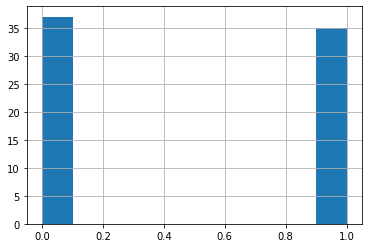

In [ ]:
ejemplos['etiqueta'].hist()

Tipología de las variables

In [ ]:
ejemplos.dtypes

fecha        object
etiqueta    float64
dtype: object

Comprobamos si hay NAs

In [ ]:
ejemplos.isna().any()

fecha       False
etiqueta    False
dtype: bool

### Ingeniería de Características

1. Retornos simples de la ventana

In [ ]:
def window_simple_returns(data):
    r = data.close.iloc[-1]/data.close.iloc[0] - 1
    return r 

In [ ]:
window_simple_returns(windata)

0.04149098860891565

2. Retornos logaritmicos de la ventana

In [ ]:
def window_log_returns(data):
    r = np.log(data.close.iloc[-1])/np.log(data.close.iloc[0])
    return r 

In [ ]:
window_log_returns(windata)

1.0045919393469211

3. Numero de días que pasan entre el máximo y el mínimo de la ventana

In [ ]:
def days_between_max_min(data):
    
    maximum = data.high.max()
    minimum = data.low.min()
    days_between_max_min_index = abs(data[data.high == maximum].index - data[data.low == minimum].index)
    days_between_max_min = (days_between_max_min_index / np.timedelta64(1, 'D')).astype(int).tolist()[0]
    return days_between_max_min

In [ ]:
days_between_max_min(windata)

27

4. Si ocurre primero el máximo o el mínimo

In [ ]:
def first_max_min(data):
    
    maximum = data.high.max()
    minimum = data.low.min()
    maximum_date = data[data.high == maximum].index
    minimum_date = data[data.low == minimum].index
    if maximum_date < minimum_date:
        first_max = 1
    else:
        first_max = 0
    
    return first_max

In [ ]:
first_max_min(windata)

0

5. Numero de veces en la ventana que se llega cerca del mínimo

In [ ]:
def treshold_min(data):
    minimum = data.low.min()
    th = 1.02
    df = data[data['low'] < th*minimum]
    df.shape[0]
             
    n = df.shape[0]*100/100
    
    return n

In [ ]:
treshold_min(windata)

14.0

6. Numero de veces en la ventana que se llega cerca del máximo

In [ ]:
def treshold_max(data):
    maximum = data.high.max()
    th = 0.99
    df= data[data['high'] > th*maximum]
    df.shape[0]
             
    n = df.shape[0]*100/100
    
    return n

In [ ]:
treshold_max(windata)

5.0

### Preprocesamiento de los datos

Inclusión de features en ejemplos

In [ ]:
ejemplos['feature1'] = np.zeros(len(ejemplos))
ejemplos['feature2'] = np.zeros(len(ejemplos))
ejemplos['feature3'] = np.zeros(len(ejemplos))
ejemplos['feature4'] = np.zeros(len(ejemplos))
ejemplos['feature5'] = np.zeros(len(ejemplos))
ejemplos['feature6'] = np.zeros(len(ejemplos))

In [ ]:
ejemplos.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2018-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2006-03-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-10-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-07-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in range(len(ejemplos)):
    
    idx = ibex.index.get_loc(ejemplos.fecha.iloc[i])
    windata = ibex.iloc[idx:idx+window]
    
    ejemplos.feature1[i] = window_simple_returns(windata)
    ejemplos.feature2[i] = window_log_returns(windata)
    ejemplos.feature3[i] = days_between_max_min(windata)
    ejemplos.feature4[i] = first_max_min(windata)
    ejemplos.feature5[i] = treshold_min(windata)
    ejemplos.feature6[i] = treshold_max(windata)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarn

In [ ]:
ejemplos.head()

,fecha,etiqueta,feature1,feature2,feature3,feature4,feature5,feature6
0,2018-03-16,0.0,0.022498,1.002422,38.0,0.0,7.0,7.0
1,2006-03-02,1.0,-0.017604,0.998106,15.0,0.0,14.0,19.0
2,2014-10-22,1.0,0.048713,1.005150,26.0,0.0,14.0,7.0
3,2018-07-23,0.0,-0.033621,0.996276,15.0,1.0,11.0,4.0
4,2015-05-25,1.0,-0.047914,0.994740,5.0,0.0,11.0,9.0


Preprocesamos los datos para conseguir un conjunto de entrenamiento de calidad

In [ ]:
def preprocesamiento(df):
  
    # Eliminar columnas con NAs
    df = df.dropna()
    
    # Cambiar orden de columnas
    df = df[['fecha', 'feature1', 'feature2', 'feature3','feature4','feature5','feature6', 'etiqueta']]
    
    # Eliminar características basadas en texto
    features_to_drop = ["fecha"]
    df = df.drop(features_to_drop, axis=1)
    

    return df

In [ ]:
ejemplos = preprocesamiento(ejemplos)
ejemplos.head()

,feature1,feature2,feature3,feature4,feature5,feature6,etiqueta
0,0.022498,1.002422,38.0,0.0,7.0,7.0,0.0
1,-0.017604,0.998106,15.0,0.0,14.0,19.0,1.0
2,0.048713,1.005150,26.0,0.0,14.0,7.0,1.0
3,-0.033621,0.996276,15.0,1.0,11.0,4.0,0.0
4,-0.047914,0.994740,5.0,0.0,11.0,9.0,1.0


### Análisis exploratorio tras la inclusión de las características

Análisis estadístico de las variables

In [ ]:
ejemplos.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,etiqueta
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.000293,0.416644,10.208333,0.208333,3.944444,2.250000,0.486111
std,0.034194,0.496454,13.579124,0.408966,5.451163,3.527558,0.503315
min,-0.141321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.998351,21.500000,0.000000,8.250000,4.000000,1.000000
max,0.104689,1.010973,41.000000,1.000000,21.000000,19.000000,1.000000


Tipología de las variables

In [ ]:
ejemplos.dtypes

feature1    float64
feature2    float64
feature3    float64
feature4    float64
feature5    float64
feature6    float64
etiqueta    float64
dtype: object

Comprobamos si hay NAs

In [ ]:
ejemplos.isna().any()

feature1    False
feature2    False
feature3    False
feature4    False
feature5    False
feature6    False
etiqueta    False
dtype: bool

### Estandarización de variables
Estandarizar las variables siempre es una buena practica.

In [ ]:
from sklearn.preprocessing import StandardScaler

Separamos nuestra variable objetivo del conjunto de datos para realizar la estandarización

In [ ]:
features = ejemplos.loc[:, ejemplos.columns !='etiqueta']
target = ejemplos.etiqueta

Estandarizamos los datos con una media = 0  y desviación típica = 1

In [ ]:
scaler = StandardScaler()
features[['feature1', 'feature2','feature3','feature4','feature5','feature6']] = scaler.fit_transform(features[['feature1', 'feature2','feature3','feature4','feature5','feature6']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
features.describe().round(decimals=3)

,feature1,feature2,feature3,feature4,feature5,feature6
count,72.000,72.000,72.000,72.000,72.000,72.000
mean,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
std,1.007,1.007,1.007,1.007,1.007,1.007
min,-4.171,-0.845,-0.757,-0.513,-0.729,-0.642
25%,-0.009,-0.845,-0.757,-0.513,-0.729,-0.642
50%,-0.009,-0.845,-0.757,-0.513,-0.729,-0.642
75%,-0.009,1.180,0.837,-0.513,0.795,0.500
max,3.075,1.206,2.283,1.949,3.151,4.782


In [ ]:
target.value_counts()

0.0    37
1.0    35
Name: etiqueta, dtype: int64

In [ ]:
target.value_counts()/target.shape[0]

0.0    0.513889
1.0    0.486111
Name: etiqueta, dtype: float64

## Árbol de decisión
Utilizaremos un árbol de decisión para realizar la clasificación de los patrones de doble suelo

#### Separación del conjunto en train/test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features.values,
                                                    target.values,
                                                    test_size=0.3,
                                                    stratify=target)

#### Inicializamos el modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
Tree = DecisionTreeClassifier(max_depth=5) 

#### Entrenamos el modelo

In [ ]:
Tree = Tree.fit(x_train, y_train)

In [ ]:
print(Tree.classes_)

[0. 1.]


#### Evaluamos el modelo 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, roc_curve

Calculamos las predicciones

In [ ]:
test_pred = Tree.predict(x_test)

In [ ]:
test_pred.shape

(22,)

- Matriz de confusion

In [ ]:
def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    
    return pd.crosstab(predicted, real)

In [ ]:
matriz_confusion(y_test, test_pred)

Real,0.0,1.0
Predicted,,
0.0,10,8
1.0,1,3


- Accuracy , AUCROC , curva ROC

Accuracy

In [ ]:
accuracy_score(y_test, test_pred)

0.5909090909090909

La clase de interés en nuestro problema es la etiqueta '1.0', por lo que 
nos interesa calcular los ratios en referencia a dicha clase.

La predicción probabilística corresponde a la posición 1

In [ ]:
train_pred_proba = Tree.predict_proba(x_train)
train_posprob = train_pred_proba[:,1]

In [ ]:
test_pred_proba = Tree.predict_proba(x_test)
test_posprob = test_pred_proba[:,1]

Área de la curva ROC

In [ ]:
roc_auc_score(y_test, test_posprob)

0.640495867768595

Curva ROC

In [ ]:
train_fpr, train_tpr, train_thr = roc_curve(y_train, train_posprob)
test_fpr, test_tpr, test_thr = roc_curve(y_test, test_posprob)

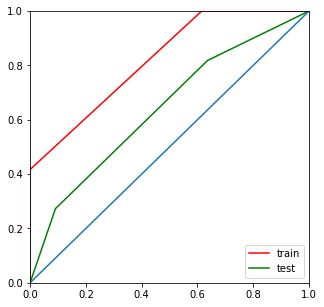

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(train_fpr, train_tpr, color='r', label='train')
plt.plot(test_fpr, test_tpr, color='g', label='test')

plt.plot([0,1],[0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')

___

In [ ]:
auc(test_fpr, test_tpr)

0.640495867768595